In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sys

In [2]:
class omniCopter():
    def __init__(self):
        self.running = True
        self.m = 1
        self.Ixx = 0.2
        self.l = 0.2
        
    def calcDerivatives(self,x,act,xd):
        # Extract the actions
        Tr = act[0]
        phird = act[1]
        Tl = act[2]
        phild = act[3]
        # Calculate the rotor forces in earth axes
        # Create the tilting rotor direction cosines
        phir = x[6]
        phil = x[7]
        Cpr_b = np.array([[1,0,0],
                          [0,math.cos(phir),-math.sin(phir)],
                          [0,math.sin(phir),math.cos(phir)]])
        Cpl_b = np.array([[1,0,0],
                          [0,math.cos(phil),-math.sin(phil)],
                          [0,math.sin(phil),math.cos(phil)]])
        Tvr = np.array([[0.0],[0.0],-Tr],dtype=object)
        Tvl = np.array([[0.0],[0.0],-Tl],dtype=object)
        Fr_b = Cpr_b @ Tvr
        Fl_b = Cpl_b @ Tvl
        # Now the body to NED axes
        phi = x[4]
        Cb_e = np.array([[1,0,0],
                          [0,math.cos(phi),-math.sin(phi)],
                          [0,math.sin(phi),math.cos(phi)]])
        # Then,
        Fr_e = Cb_e @ Fr_b
        Fl_e = Cb_e @ Fl_b
        # Total forces acting on the body are then,
        g = 10
        F = Fr_e + Fl_e + Cb_e @ np.array([[0],[0],[self.m * g]],dtype=object)
        # Now the moments. First transgform the moment arms into NED axes
        r_cg_pr_e = Cb_e @ np.array([[0],[self.l],[0]],dtype=object)
        r_cg_pl_e = Cb_e @ np.array([[0],[-self.l],[0]],dtype=object)
        # Now calculate the torque vector
        Tq = np.cross(np.transpose(r_cg_pr_e),np.transpose(Fr_e)) \
           + np.cross(np.transpose(r_cg_pl_e),np.transpose(Fl_e)) 
        #
        # With the forces and moments found, we can compute the linear and 
        # angular accelerations.
        ydd = F[1][0] / self.m
        zdd = F[2][0] / self.m
        phidd = Tq[0][1] / self.Ixx
        # Return the derivative vectors
        xd[0] = x[1]
        xd[1] = ydd
        xd[2] = x[3]
        xd[3] = zdd
        xd[4] = x[5]
        xd[5] = phidd
        xd[6] = phird
        xd[7] = phild
        return xd
        
    def runningStatus(self,s):
        self.running = s
        return self.running

In [27]:
class LanderEnv():
    def __init__(self):
        self.oc = omniCopter()
        
        self.ylim = [-5, 5]
        self.zlim = [-10, 0]
        
        self.tf = 2
        
    def reset(self):
        self.yplt = np.array([])
        self.zplt = []
        self.phiplt = []
        self.tplt = []
        
        y0 = random.randint(-3, 3)
        z0 = random.randint(-9, -6)
        phi0 = random.uniform(-0.75, 0.75)
        self.current_state = np.array([[y0],[0.0],[z0],[0.0],[phi0],[0.0],[0.0],[0.0]])
        
        self.t = np.array([0.0])
        self.reward = 0
        
        return self.current_state
    
    def get_reward(self, action, weights=[1,1,1,0.05,1,0.0015,1]):
        z_reward = self.current_state[2][0] #Z axis
        y_reward = -self.yplt.std() #Y axis
        p_reward = -np.abs(self.current_state[4][0] * 10) #Phi 
        t_reward = -len(self.tplt) #time
        a_reward = -np.abs(action[0][0]) -np.abs(action[2][0]) #Fuel(thrust)
        v_reward = -(self.current_state[1][0] + self.current_state[3][0] \
                     + self.current_state[5][0]) * ((20 + self.current_state[2][0])**2) #Velocity
        l_reward = 100 if -self.current_state[2][0] < 0.05 else 0
        total_reward = weights[0] * z_reward + weights[1] * y_reward + weights[2] * p_reward + \
                        weights[3] * t_reward + weights[4] * a_reward + weights[5] * v_reward + weights[6] * l_reward
        return total_reward, [z_reward, y_reward, p_reward, t_reward, a_reward, v_reward, l_reward, total_reward]
        
    
    def step(self, action):
        dt = np.array([0.01])
        xd = np.zeros((8,1))
        xd = self.oc.calcDerivatives(self.current_state, action, xd)
        
        self.current_state += xd*dt
        self.t += dt
        
        self.yplt = np.append(self.yplt,self.current_state[0])
        self.zplt = np.append(self.zplt,-self.current_state[2])
        
        
        self.phiplt = np.append(self.phiplt,self.current_state[4])
        self.tplt = np.append(self.tplt,self.t)
        
        valid = (self.current_state[0][0] > self.ylim[0]) and (self.current_state[0][0] < self.ylim[1]) \
                and (self.current_state[2][0] > self.zlim[0]) and (self.current_state[2][0] < self.zlim[1])
        running = self.oc.runningStatus(valid and self.t<self.tf)
        
        self.reward, reward_breakdown = self.get_reward(action)
        
        info = {'graphs': {'y':self.yplt, 'z': self.zplt, 'phi': self.phiplt, 't': self.tplt},
                'reward_breakdown': reward_breakdown}
        
        return self.current_state, self.reward, not running, info

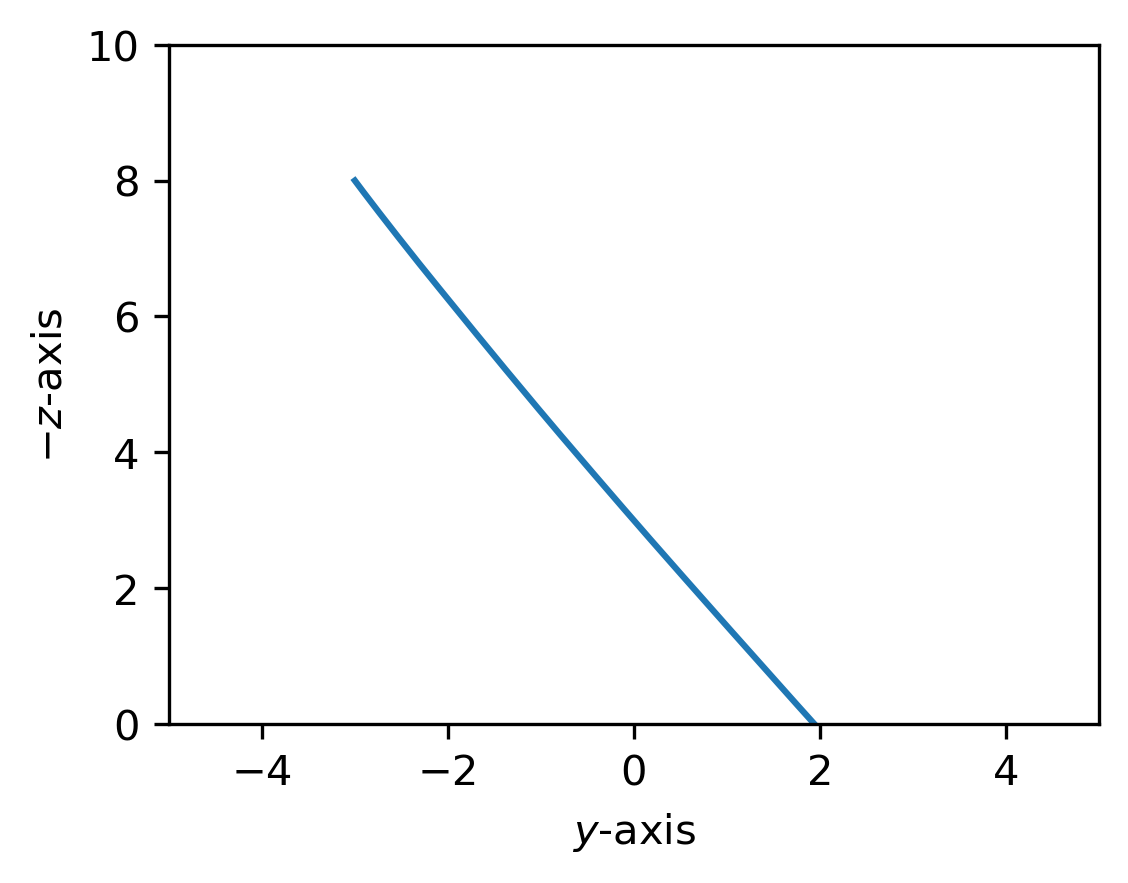

In [28]:
env = LanderEnv()
state = env.reset()

done = False
while not done:
    action = np.array([[random.randint(0, 5)],[0.1],[random.randint(0, 5)],[0.1]])
    state, reward, done, info = env.step(action)

plt.figure(figsize=(4,3),dpi=300)
plt.plot(info['graphs']['y'],info['graphs']['z'],label='omnicopter')
plt.xlabel(r'$y$-axis')
plt.ylabel(r'$-z$-axis')
plt.axis([-5,5,0,10])
plt.show()

In [29]:
rewards = []

In [30]:
for i in range(10000):
    env = LanderEnv()
    state = env.reset()

    done = False
    while not done:
        action = np.array([[random.randint(0, 5)],[0.1],[random.randint(0, 5)],[0.1]])
        state, reward, done, info = env.step(action)
        rewards.append(info['reward_breakdown'])
    print(f'\r{i}', end='   ')
    sys.stdout.flush()

9999                                                                                                                                                                                                                                                                                                                                                                                                                              

In [21]:
import pandas as pd

In [24]:
df = pd.DataFrame(rewards, columns = ['z_reward', 'y_reward', 'p_reward', 't_reward', 'a_reward', 'v_reward', 'l_reward', 'total_reward']) 

In [25]:
df.head()

,z_reward,y_reward,p_reward,t_reward,a_reward,v_reward,l_reward,total_reward
0,-6.000000,-0.000000,-1.207431,-1,-3.0,-11.967538,0,-23.174968
1,-5.999305,-0.000042,-1.207431,-2,-3.0,-23.944000,0,-36.150778
2,-5.997915,-0.000105,-1.207431,-3,-6.0,-30.815594,0,-47.021045
3,-5.996128,-0.000179,-1.207431,-4,-4.0,-41.113252,0,-56.316990
4,-5.993745,-0.000273,-1.207431,-5,-0.0,-58.239007,0,-70.440456


In [26]:
df.describe()

,z_reward,y_reward,p_reward,t_reward,a_reward,v_reward,l_reward,total_reward
count,1.754996e+06,1.754996e+06,1.754996e+06,1.754996e+06,1.754996e+06,1.754996e+06,1.754996e+06,1.754996e+06
mean,-5.219382e+00,-2.721205e-01,-3.700596e+00,-8.778129e+01,-4.999423e+00,-1.094544e+03,6.535058e-01,-1.195864e+03
std,2.340881e+00,3.319604e-01,2.148453e+00,5.156933e+01,2.415245e+00,1.084756e+03,8.057515e+00,1.123613e+03
min,-9.000001e+00,-2.240289e+00,-7.499938e+00,-2.000000e+02,-1.000000e+01,-6.076720e+03,0.000000e+00,-6.224061e+03
25%,-6.978736e+00,-4.002190e-01,-5.534912e+00,-1.300000e+02,-7.000000e+00,-1.616501e+03,0.000000e+00,-1.752182e+03
50%,-5.614513e+00,-1.388501e-01,-3.710779e+00,-8.700000e+01,-5.000000e+00,-7.157241e+02,0.000000e+00,-8.179992e+02
75%,-3.554957e+00,-2.931565e-02,-1.850327e+00,-4.400000e+01,-3.000000e+00,-2.579050e+02,0.000000e+00,-3.249454e+02
max,9.939601e-02,-0.000000e+00,-1.170111e-05,-1.000000e+00,-0.000000e+00,-0.000000e+00,1.000000e+02,-1.570541e+01


In [31]:
df2 = pd.DataFrame(rewards, columns = ['z_reward', 'y_reward', 'p_reward', 't_reward', 'a_reward', 'v_reward', 'l_reward', 'total_reward']) 
df2.describe()

,z_reward,y_reward,p_reward,t_reward,a_reward,v_reward,l_reward,total_reward
count,1.721557e+06,1.721557e+06,1.721557e+06,1.721557e+06,1.721557e+06,1.721557e+06,1.721557e+06,1.721557e+06
mean,-5.227895e+00,-2.723596e-01,-3.695208e+00,-8.778130e+01,-4.998149e+00,-1.105965e+03,6.446490e-01,-1.959697e+01
std,2.342156e+00,3.306667e-01,2.139221e+00,5.158324e+01,2.414357e+00,1.096604e+03,8.003085e+00,8.830316e+00
min,-9.000000e+00,-2.243378e+00,-7.499365e+00,-2.000000e+02,-1.000000e+01,-6.190294e+03,0.000000e+00,-3.799503e+01
25%,-6.980814e+00,-4.005072e-01,-5.517961e+00,-1.300000e+02,-7.000000e+00,-1.633657e+03,0.000000e+00,-2.292782e+01
50%,-5.622815e+00,-1.401653e-01,-3.683212e+00,-8.700000e+01,-5.000000e+00,-7.222599e+02,0.000000e+00,-2.009431e+01
75%,-3.562950e+00,-3.005574e-02,-1.848242e+00,-4.400000e+01,-3.000000e+00,-2.594045e+02,0.000000e+00,-1.731232e+01
max,9.849644e-02,-0.000000e+00,-7.999458e-04,-1.000000e+00,-0.000000e+00,-0.000000e+00,1.000000e+02,8.718141e+01
